In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, kruskal
from scikit_posthocs import posthoc_dunn

In [16]:
def erro_relativo(df):
    operadores = [i for i in df.columns[1:-1]]
    for op in operadores:
        df[op] = (df[op] - df['Otimo']) / df['Otimo']
    return df

In [17]:
def box_plot(df, save=False):
    fig, ax = plt.subplots()
    ax.boxplot([df[col] for col in df.columns[1:-1]])
    ax.set_ylabel('Erro relativo')
    ax.set_xlabel('Operadores de crossover')
    plt.xticks([n for n in range(1, 13)], 
               ['Order-based', 'Position-based', 'PMX', 'One-point', 'Two-point', 'Two-point 2', 
                'OX2', 'Linear', 'Sequence-based', 'Loop-based', 'Two-cut PTL', 'Sem crossover'])
    plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right', fontsize='x-small')
    plt.grid(linewidth=0.4, axis='y')
    plt.plot()
    if save:
        plt.savefig('teste.jpg', dpi=300, bbox_inches='tight')

In [18]:
def highlight_cells(val: float):
    if val < 0.05:
        color = '#d14133'
    elif val == 1:
        color = '#636363'
    elif val > 0.05:
        color = '#399234'
    else:
        color = ''
    return 'background-color: {}'.format(color)

In [19]:
def teste_kruskal(*series):
    stat, p = kruskal(*series)
    if p > 0.05:
        print(f"NÃO há diferença significativa entre os operadores | p-value = {p}")
    else:
        print(f"Há diferença significativa entre os operadores | p-value = {p}")

# Dados

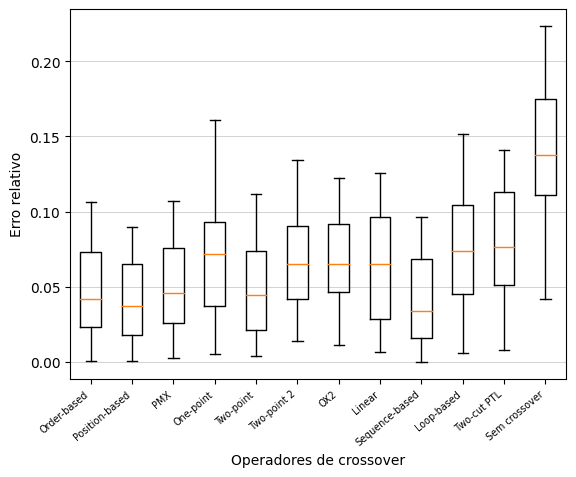

In [20]:
# Teste 1
df_1 = pd.read_csv('crossover_operators_124_120.csv', sep=',')
df_1 = erro_relativo(df_1)
box_plot(df_1, save=False)

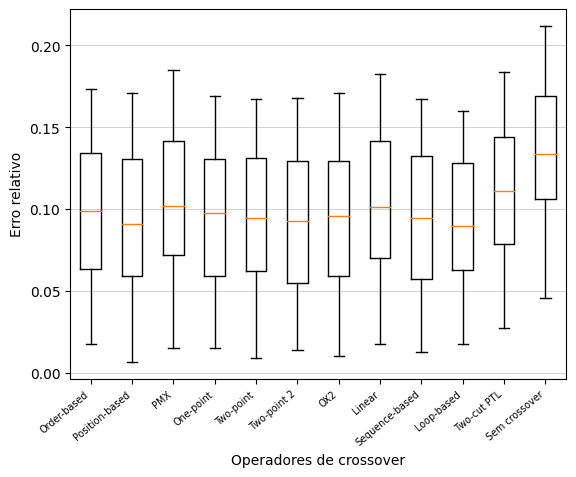

In [21]:
# Teste 2
df_2 = pd.read_csv('crossover_operators_163_11.csv', sep=',')
df_2 = erro_relativo(df_2)
box_plot(df_2, save=False)

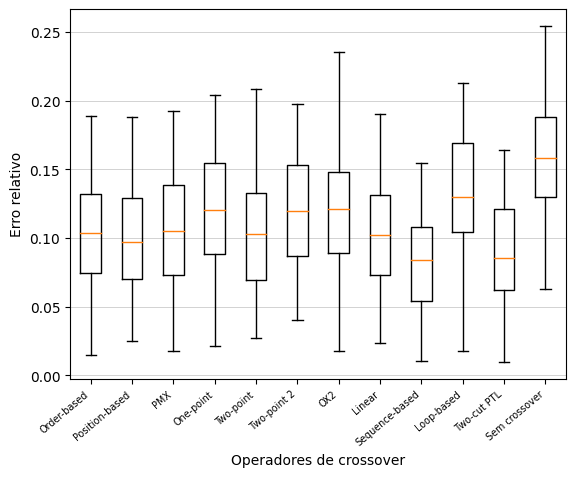

In [22]:
# Teste 3
df_3 = pd.read_csv('crossover_operators_18_133.csv', sep=',')
df_3 = erro_relativo(df_3)
box_plot(df_3, save=False)

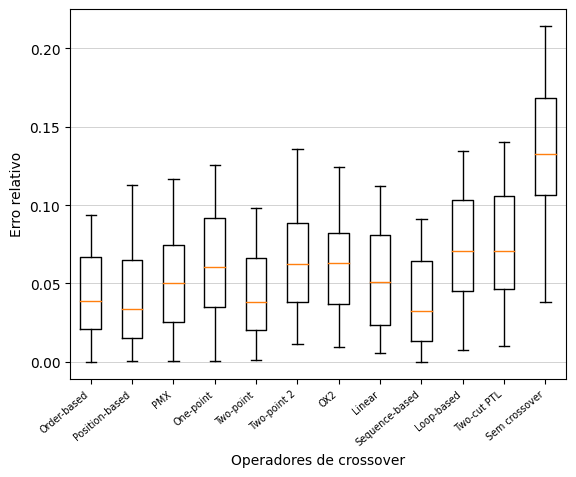

In [23]:
# Teste 4
# Este foi o teste mais abrangente e utilizado no artigo
df_4 = pd.read_csv('crossover_operators_194_133.csv', sep=',')
df_4 = erro_relativo(df_4)
box_plot(df_4, save=False)

## Análise exploratória de desempenho

In [24]:
df_4 = df_4.drop(columns=["Instancia", "Otimo"])

In [25]:
df_4.describe()

,OrderBased,PositionBased,PMX,OnePoint,TwoPoint,TwoPointPermutation,OrderTwo,Linear,SequenceBased,LoopBased,TwoCutPTL,NoCross
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.043338,0.039534,0.051580,0.063383,0.042329,0.063949,0.062097,0.052964,0.037777,0.072586,0.073065,0.133057
std,0.025781,0.026794,0.029898,0.033027,0.025177,0.030981,0.029898,0.031088,0.027611,0.035852,0.036242,0.043812
min,0.000000,0.000719,0.000736,0.000349,0.001438,0.011287,0.009685,0.005887,0.000000,0.007709,0.010279,0.038263
25%,0.020917,0.015512,0.025167,0.034718,0.020338,0.037949,0.036899,0.023205,0.013191,0.045484,0.046160,0.106447
50%,0.039117,0.033837,0.050506,0.060502,0.038082,0.062654,0.063207,0.050689,0.032326,0.070490,0.070500,0.132358
75%,0.066790,0.065225,0.074362,0.091595,0.066059,0.088689,0.081883,0.080904,0.064343,0.103177,0.106041,0.168247
max,0.093810,0.112631,0.116555,0.125332,0.098382,0.135626,0.124173,0.112365,0.091344,0.134791,0.140246,0.214305


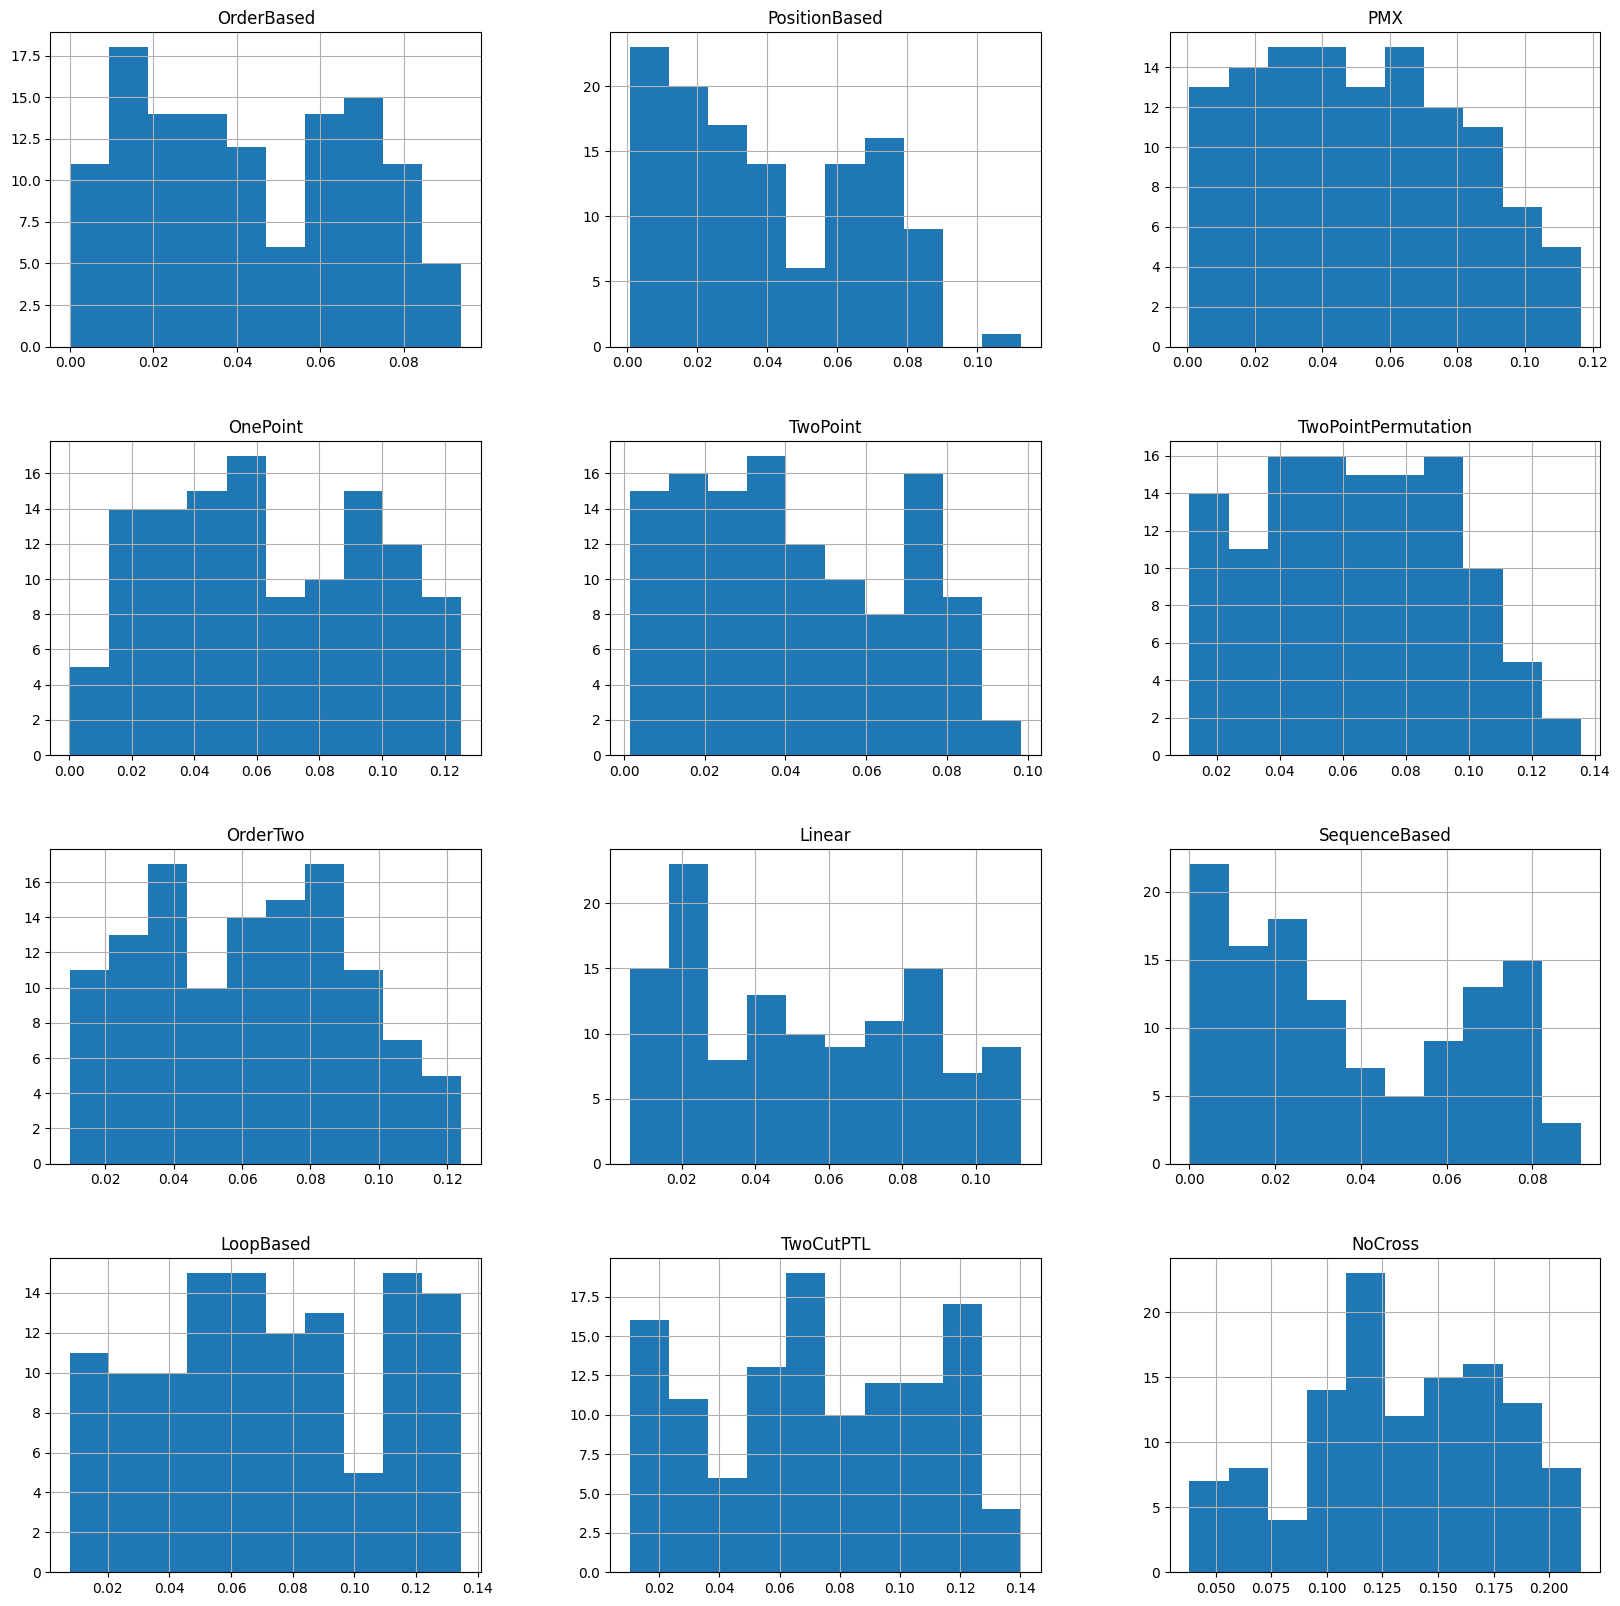

In [26]:
df_4.hist(figsize=(20, 20));

### Teste de normalidade

In [28]:
operadores = list(df_4.columns)

In [29]:
# Teste de Shapiro-Wilk
print("Testando cada operador:")
for o in operadores:
    stat, p = shapiro(df_4[o])
    print(f"{o} | p-value = {p}")
stat, p = shapiro(df_4)
print(f"\nTeste com todos os operadores:\np-value = {p}")

Testando cada operador:
OrderBased | p-value = 9.549258538754657e-05
PositionBased | p-value = 1.527369204268325e-05
PMX | p-value = 0.002362316008657217
OnePoint | p-value = 0.002063020830973983
TwoPoint | p-value = 0.0002633631811477244
TwoPointPermutation | p-value = 0.007717666681855917
OrderTwo | p-value = 0.013912549242377281
Linear | p-value = 9.953955668606795e-06
SequenceBased | p-value = 1.2289154938116553e-06
LoopBased | p-value = 0.0010863932548090816
TwoCutPTL | p-value = 0.00042590382508933544
NoCross | p-value = 0.03739025443792343

Teste com todos os operadores:
p-value = 3.069353526357723e-22


Ao nível de 5% de significância, rejeita-se a hipótese nula (os dados seguem distribuição normal) para todos os operadores implementados. Devemos utilizar testes não paramétricos.

### Teste de Kruskal-Wallis para determinar diferenças de desempenho entre operadores

In [30]:
d = df_4.copy()

#### Testando todos os operadores

In [31]:
teste_kruskal(d["OrderBased"], d["PositionBased"], d["PMX"], d["OnePoint"],
              d["TwoPoint"], d["TwoPointPermutation"], d["OrderTwo"], d["Linear"],
              d["SequenceBased"], d["LoopBased"], d["TwoCutPTL"], d["NoCross"])

Há diferença significativa entre os operadores | p-value = 9.339069837476372e-75


#### Removendo os dados do "NoCross"

In [32]:
teste_kruskal(d["OrderBased"], d["PositionBased"], d["PMX"], d["OnePoint"],
              d["TwoPoint"], d["TwoPointPermutation"], d["OrderTwo"], d["Linear"],
              d["SequenceBased"], d["LoopBased"], d["TwoCutPTL"])

Há diferença significativa entre os operadores | p-value = 2.938028691784731e-31


#### Operadores com mediana do erro relativo abaixo de 6%

In [33]:
teste_kruskal(d["OrderBased"], d["PositionBased"], d["TwoPoint"], 
              d["SequenceBased"], d["PMX"], d["Linear"])

Há diferença significativa entre os operadores | p-value = 5.9875050160252964e-05


#### Operadores com mediana do erro relativo inferior a 5%

In [34]:
teste_kruskal(d["SequenceBased"], d["PositionBased"], d["TwoPoint"], d["OrderBased"])

NÃO há diferença significativa entre os operadores | p-value = 0.22800141832141452


Isso significa que a mediana do erro relativo destes operadores são estatisticamente iguais e encontramos os operadores cujo desempenho são significativamente superiores aos demais.

### Teste de Dunn para encontrar diretamente quais operadores são distintos

In [35]:
# Ordenando operadores por mediana do erro relativo
sort = sorted(dict(d.median()).items(), key=lambda x:x[1])

In [36]:
# Colunas ordenadas
colunas = [sort[i][0] for i in range(len(sort))]

In [37]:
# Reorganizando o dataframe
d = d[colunas]

In [38]:
# Dicionário para renomear colunas
rename_dict = dict(zip(range(1, 13), d.columns))

In [39]:
# Matriz do teste de Dunn para cada par
p_values = posthoc_dunn(d.T.values, p_adjust="holm")
p_values = p_values.rename(index=rename_dict, columns=rename_dict)
p_values.style.applymap(highlight_cells)

,SequenceBased,PositionBased,TwoPoint,OrderBased,PMX,Linear,OnePoint,TwoPointPermutation,OrderTwo,LoopBased,TwoCutPTL,NoCross
SequenceBased,1.000000,1.000000,1.000000,1.000000,0.049547,0.015263,0.000001,0.000000,0.000001,0.000000,0.000000,0.000000
PositionBased,1.000000,1.000000,1.000000,1.000000,0.148896,0.051498,0.000005,0.000002,0.000009,0.000000,0.000000,0.000000
TwoPoint,1.000000,1.000000,1.000000,1.000000,0.786413,0.410932,0.000189,0.000079,0.000319,0.000000,0.000000,0.000000
OrderBased,1.000000,1.000000,1.000000,1.000000,1.000000,0.664864,0.000549,0.000247,0.000896,0.000000,0.000000,0.000000
PMX,0.049547,0.148896,0.786413,1.000000,1.000000,1.000000,0.304533,0.184586,0.410932,0.000973,0.000678,0.000000
Linear,0.015263,0.051498,0.410932,0.664864,1.000000,1.000000,0.639700,0.413059,0.786413,0.003842,0.002689,0.000000
OnePoint,0.000001,0.000005,0.000189,0.000549,0.304533,0.639700,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
TwoPointPermutation,0.000000,0.000002,0.000079,0.000247,0.184586,0.413059,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
OrderTwo,0.000001,0.000009,0.000319,0.000896,0.410932,0.786413,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
LoopBased,0.000000,0.000000,0.000000,0.000000,0.000973,0.003842,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


Essa matriz confirma a suspeita de que os 4 operadores com melhor desempenho não possuem diferenças estatisticamente significativas. <br>
Também fica nítido que a implementação de qualquer estratégia de crossover é bastante superior às soluções aleatórias do problema.

## Boxplot dos melhores operadores

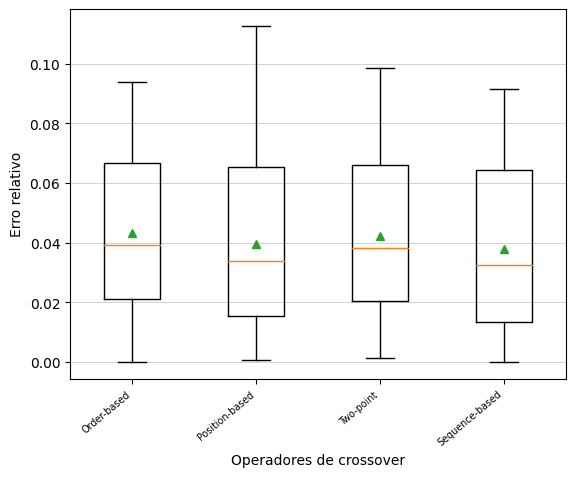

In [40]:
best_ops = ['OrderBased', 'PositionBased', 'TwoPoint', 'SequenceBased']
fig, ax = plt.subplots()
ax.boxplot([df_4[col] for col in best_ops], showmeans=True)
ax.set_ylabel('Erro relativo')
ax.set_xlabel('Operadores de crossover')
plt.xticks([n for n in range(1, 5)], 
            ['Order-based', 'Position-based', 'Two-point', 'Sequence-based'])
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right', fontsize='x-small')
plt.grid(linewidth=0.4, axis='y')
plt.plot();
# plt.savefig('best.jpg', dpi=300, bbox_inches='tight')

Estes são os 4 melhores operadores que não apresentam diferenças significativas de desempenho.

# Dados dos tempos de processamento de cada operador

In [41]:
df_time = pd.read_csv('crossover_operators_time.csv', sep=',').drop(columns=['Otimo'])
df_time.tail()

,Instancia,OrderBased,PositionBased,PMX,OnePoint,TwoPoint,TwoPointPermutation,OrderTwo,Linear,SequenceBased,LoopBased,TwoCutPTL,NoCross
7,100J_10M_0.txt,118.0863,144.2060,118.7481,121.1649,127.1250,114.4761,115.3651,114.5736,121.3949,105.2340,108.4729,96.8673
8,100J_20M_0.txt,166.8574,184.1279,168.8423,166.6945,166.2031,164.4863,165.9179,163.8848,162.6187,160.5300,165.6078,152.7231
9,200J_10M_0.txt,171.4962,242.6688,169.7032,172.6311,172.9254,171.5149,172.2488,171.0298,169.7801,164.9708,172.5439,150.3833
10,200J_20M_0.txt,289.5660,361.7562,289.7452,289.0367,292.0338,291.7771,289.5618,290.9442,287.5705,281.0689,290.7138,269.1009
11,500J_20M_0.txt,730.1994,1161.1870,708.2471,872.9151,925.1488,934.8502,992.6444,940.8216,932.5657,691.3687,703.2229,643.9989


## Análise exploratória de tempo de processamento

In [42]:
# Estatística descritiva dos tempos de processamento
df_time.describe()

,OrderBased,PositionBased,PMX,OnePoint,TwoPoint,TwoPointPermutation,OrderTwo,Linear,SequenceBased,LoopBased,TwoCutPTL,NoCross
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,165.508092,220.559600,163.964392,178.339150,184.097117,184.355975,187.807083,182.722033,180.744183,158.927708,164.078542,148.528433
std,190.755359,310.069978,184.982720,229.404074,243.623619,246.118782,262.467465,248.347580,246.380020,180.135449,183.198138,168.592782
min,50.547400,54.094600,51.513800,49.664700,49.679700,51.812100,48.882400,47.872400,49.085300,48.055800,50.536100,46.214000
25%,64.087350,65.758500,63.045775,63.191375,63.904375,63.893900,63.394300,64.085250,62.812725,62.790500,64.148175,59.896350
50%,99.791300,118.215950,99.698250,105.009300,107.860200,100.519350,100.038750,97.614900,94.827550,97.336400,98.867250,84.844450
75%,168.017100,198.763125,169.057525,168.178650,167.883675,166.243450,167.500625,165.671050,164.409050,161.640200,167.341825,150.968250
max,730.199400,1161.187000,708.247100,872.915100,925.148800,934.850200,992.644400,940.821600,932.565700,691.368700,703.222900,643.998900


In [43]:
# Download da estatística descritiva para o excel
# file_name = 'times.xlsx'
# df_time.describe().to_excel(file_name)

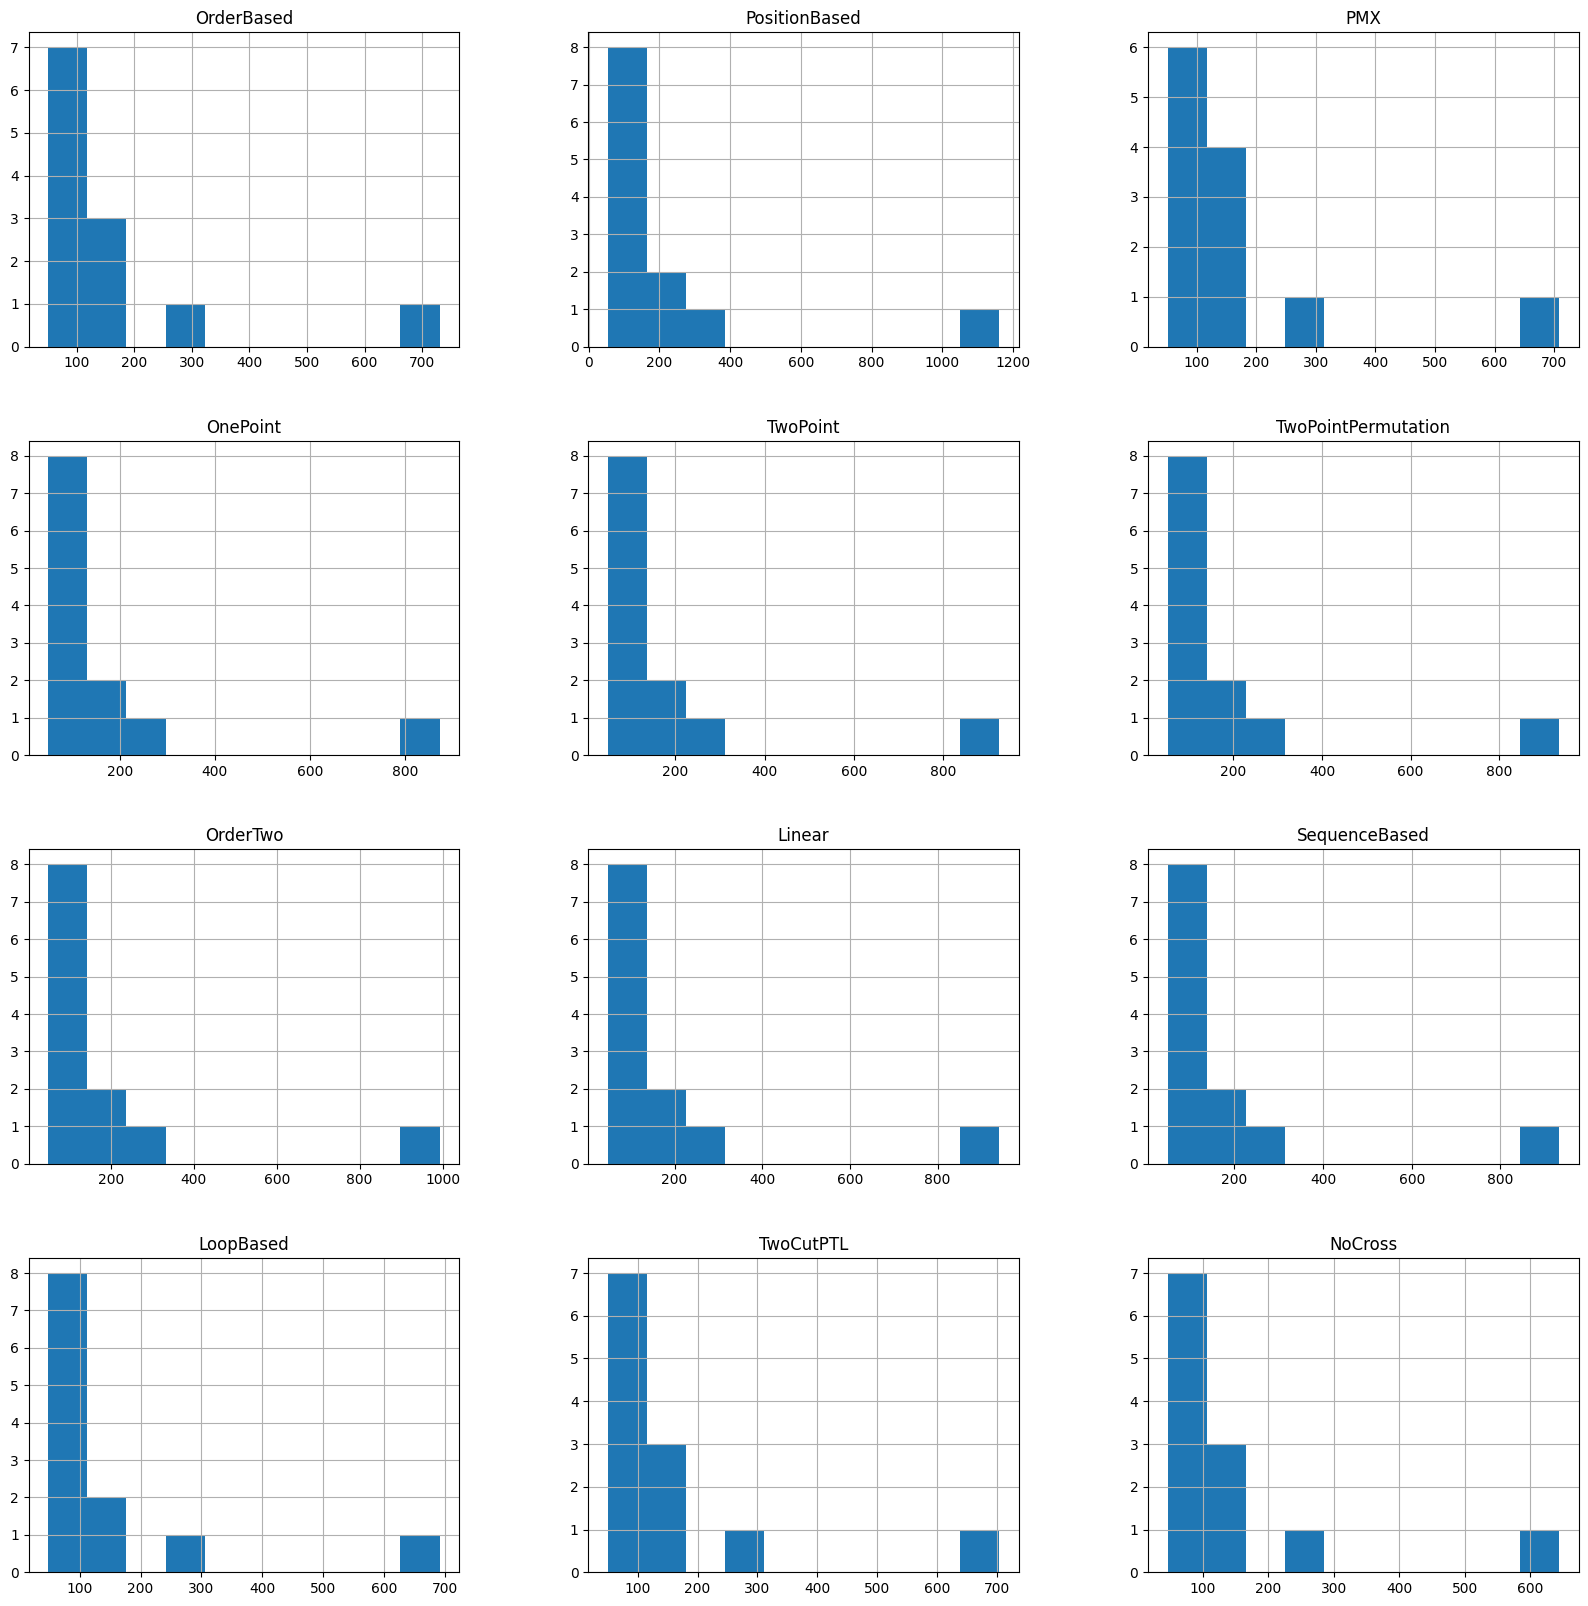

In [44]:
df_time.hist(figsize=(20, 20));

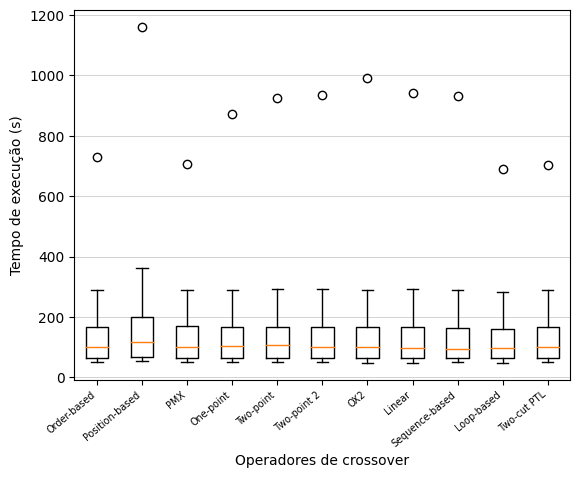

In [48]:
# Boxplot
fig, ax = plt.subplots()
ax.boxplot([df_time[col] for col in df_time.columns[1:-1]])
ax.set_ylabel('Tempo de execução (s)')
ax.set_xlabel('Operadores de crossover')
plt.xticks([n for n in range(1, 13)], 
           ['Order-based', 'Position-based', 'PMX', 'One-point', 'Two-point', 'Two-point 2', 
            'OX2', 'Linear', 'Sequence-based', 'Loop-based', 'Two-cut PTL', 'Sem crossover'])
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right', fontsize='x-small')
plt.grid(linewidth=0.4, axis='y')
plt.plot();

## Teste de Kruskal-Wallis para determinar se há diferenças significativas no tempo de processamento

In [46]:
d = df_time.copy()

In [47]:
teste_kruskal(d["OrderBased"], d["PositionBased"], d["PMX"], d["OnePoint"],
              d["TwoPoint"], d["TwoPointPermutation"], d["OrderTwo"], d["Linear"],
              d["SequenceBased"], d["LoopBased"], d["TwoCutPTL"], d["NoCross"])

NÃO há diferença significativa entre os operadores | p-value = 0.9998466595153649


Desta forma, conclui-se que não há diferença estatisticamente significativa entre os tempos de execução dos operadores de crossover.